# Exercise 1. Convolutional Autoencoder

In [0]:
import numpy as np
np.random.seed(1)
import torch
import torch.optim as optim
torch.manual_seed(1)
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
from IPython.display import display


## Load the MNIST datasets into DataLoaders

In [0]:
hparams = {
    'batch_size':64,
    'num_epochs':20,
    'val_batch_size':64,
    'test_batch_size':64,
    'learning_rate':1e-3
}

mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

length_train = len(mnist_trainset)

train_dataset, validation_dataset = torch.utils.data.random_split(mnist_trainset, [int(0.95*length_train), int(0.05*length_train)])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=hparams['batch_size'], 
    shuffle=True,drop_last=True) 

val_loader = torch.utils.data.DataLoader(validation_dataset,
                                         batch_size=hparams['val_batch_size'], 
                                         shuffle=True,drop_last=False)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False,drop_last=False)


## Define our Network Architecture

In [0]:
class Encoder(nn.Module):

   def __init__(self, bottleneck_size):
     super().__init__()

     self.conv1 = nn.Conv2d(1,16,3,padding=1)
     self.pool  = nn.MaxPool2d(2,2)
     self.conv2 = nn.Conv2d(16,4,3,padding=1)
     self.bottleneck_layer = nn.Linear(4 * 7 * 7, bottleneck_size)

   def forward(self,x):
     
      x = F.relu(self.conv1(x))
      x = self.pool(x)
      x = F.relu(self.conv2(x))
      x = self.pool(x)  
      x = x.view(-1, 4 * 7 * 7)
      x = self.bottleneck_layer(x)

      return x

class Decoder(nn.Module):
   def __init__(self, bottleneck_size):
     super().__init__()
     self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
     self.bottleneck_reconstruct = nn.Linear(bottleneck_size, 4*7*7)

   def forward(self,x):
     x = self.bottleneck_reconstruct(x)
     x = x.view(-1, 4, 7, 7)
     x = F.relu(self.t_conv1(x))
     x = F.sigmoid(self.t_conv2(x))
            
     return x

class CAE(nn.Module):

  def __init__(self, enc, dec):
    super().__init__()
    self.encoder = enc
    self.decoder = dec

  def forward(self,x):
    x = self.encoder(x)
    predicted = self.decoder(x)
    return predicted


##Now we have to train the network for a number of epochs
In order to make this in a propper manner we define a train() function

In [0]:
def train(model, num_epochs):
  # Prepare the GPU and the model to start training
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  costFunc = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr = hparams['learning_rate']) # learning rate chosen at random
  
  trainLoss =[]
  validationLoss =[]
  
  for epoch in range(num_epochs):
    closs = 0
    valloss=0
    model.train()
    for batch_idx, (data,_) in enumerate(train_loader):
      data = data.to(device)
      prediction = model(data)
      loss = costFunc(prediction,data)
      closs += loss.item()*data.size(0) 

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,closs/len(train_loader)))
    trainLoss.append(closs/len(train_loader))
    
    # Let's check accuracy with our validation set
    model.eval()
    for index,(data,_)  in enumerate(val_loader):
        data = data.to(device)
        prediction = model(data)
        loss = costFunc(prediction,data)
        valloss += loss.item()*data.size(0)
    validationLoss.append(valloss/len(val_loader))
  return {"trainLoss":trainLoss,"validationLoss":validationLoss}

## Analysis with different  bottleneck sizes



In [0]:
bottleneckSizes = np.linspace(2,60,15,dtype=np.int32)
bottleneckSizes = [2, 6, 10, 20]
loss= []
models = []
for bottleneckSize in bottleneckSizes:
    encoder = Encoder(bottleneckSize)
    decoder = Decoder(bottleneckSize)
    model = CAE(encoder,decoder)
    modelloss=train(model,hparams["num_epochs"])
    loss.append(modelloss)
    models.append(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 	Training Loss: 53.050978
Epoch: 1 	Training Loss: 49.246518
Epoch: 2 	Training Loss: 48.534185
Epoch: 3 	Training Loss: 48.220718
Epoch: 4 	Training Loss: 48.031250
Epoch: 5 	Training Loss: 47.825294
Epoch: 6 	Training Loss: 47.728951
Epoch: 7 	Training Loss: 47.645035
Epoch: 8 	Training Loss: 47.557546
Epoch: 9 	Training Loss: 47.494773
Epoch: 10 	Training Loss: 47.404673
Epoch: 11 	Training Loss: 47.360180
Epoch: 12 	Training Loss: 47.321257
Epoch: 13 	Training Loss: 47.266986
Epoch: 14 	Training Loss: 47.228733
Epoch: 15 	Training Loss: 47.202557
Epoch: 16 	Training Loss: 47.176410
Epoch: 17 	Training Loss: 47.156052
Epoch: 18 	Training Loss: 47.136804
Epoch: 19 	Training Loss: 47.123148
Epoch: 0 	Training Loss: 50.094926
Epoch: 1 	Training Loss: 45.759228
Epoch: 2 	Training Loss: 44.891997
Epoch: 3 	Training Loss: 44.371091
Epoch: 4 	Training Loss: 44.169899
Epoch: 5 	Training Loss: 44.023679
Epoch: 6 	Training Loss: 43.893717
Epoch: 7 	Training Loss: 43.797586
Epoch: 8 	

In [0]:
model

CAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bottleneck_layer): Linear(in_features=196, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (bottleneck_reconstruct): Linear(in_features=20, out_features=196, bias=True)
  )
)

Text(0.5, 1.0, 'Training MSE for different bottlenecks')

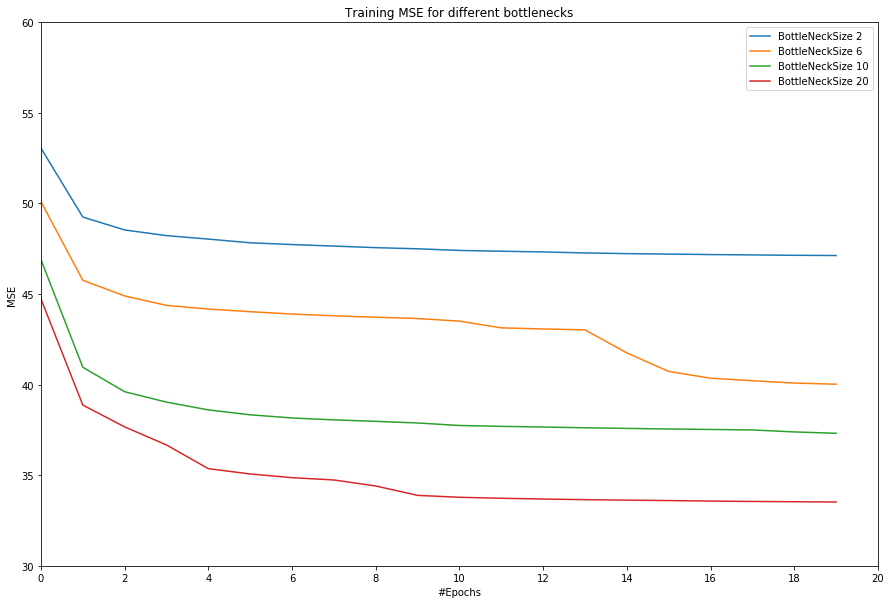

In [0]:
trainlosses = [los["trainLoss"] for los in loss]
vallosses = [los["validationLoss"] for los in loss]

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(10)
ax.axis([0 ,20,30,60 ])
ax.plot(range(hparams["num_epochs"]),np.array(trainlosses).T)
ax.legend([ f"BottleNeckSize {bottleneckSize}" for bottleneckSize in bottleneckSizes])
ax.set_xlabel('#Epochs')
ax.set_ylabel('MSE')
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_title('Training MSE for different bottlenecks')

## Image reconstruction error (MSE) on the MNIST validation and test sets.

In [0]:
device = torch.device("cpu")
costFunc = nn.MSELoss()
testLoss =[]
validationLoss =[]
bottleneckSizes = np.linspace(2,60,15,dtype=np.int32)
def num_params(model):
  return sum(p.numel() for p in model.parameters())

for i,model in enumerate(models):
    model.eval()
    model.to("cpu")
    for index,(data,_)  in enumerate(val_loader):
      data = data.to(device)
      prediction = model(data)
      loss = costFunc(prediction,data)
      valloss = loss.item()
      validationLoss.append({"bottleneckSize":bottleneckSizes[i],"validationLoss":valloss,"#params": num_params(model) })
    for index,(data,_)  in enumerate(test_loader):
      data = data.to(device)
      prediction = model(data)
      loss = costFunc(prediction,data)
      testloss = loss.item()
      testLoss.append({"bottleneckSize":bottleneckSizes[i],"testLoss":testloss,"#params": num_params(model)})

pd.set_option('display.max_rows', None)
validationtable= pd.DataFrame(validationLoss)
testtable =pd.DataFrame(testLoss)
display(validationtable)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,bottleneckSize,validationLoss,#params
0,2,0.663921,2059
1,2,0.761435,2059
2,2,0.691549,2059
3,2,0.741942,2059
4,2,0.692267,2059
5,2,0.757086,2059
6,2,0.741799,2059
7,2,0.716445,2059
8,2,0.713173,2059
9,2,0.707921,2059


In [0]:
display(testtable)

,bottleneckSize,testLoss,#params
0,2,0.681007,2059
1,2,0.702079,2059
2,2,0.679793,2059
3,2,0.671265,2059
4,2,0.720694,2059
5,2,0.680722,2059
6,2,0.699816,2059
7,2,0.708886,2059
8,2,0.721732,2059
9,2,0.729770,2059


## Showing original images and their reconstruction.
Now we take a bunch of images from the test set and see how the network behaves after being trained.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


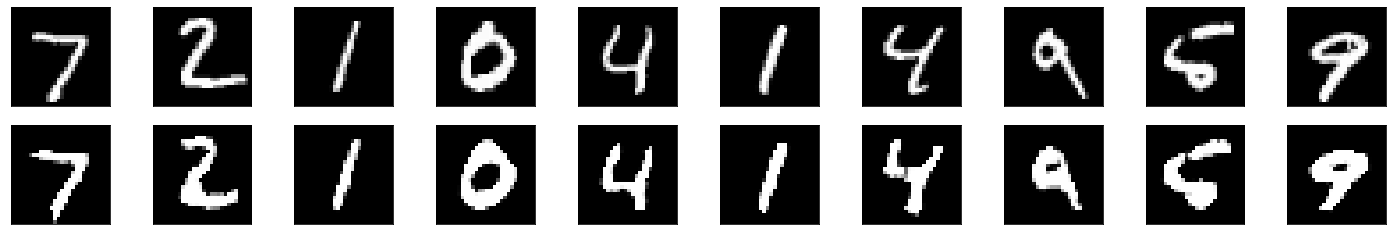

In [0]:
dataiter = iter(test_loader)
images, _ = dataiter.next()
encoder_decoder = models[3]
encoder_decoder.eval()
encoder_decoder.to("cpu")

prediction = encoder_decoder(images)
images = images.numpy()

prediction = prediction.detach().numpy()
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, prediction], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Generating images by injecting random values as input to the decoder

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


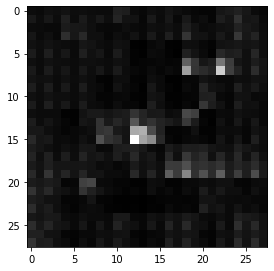

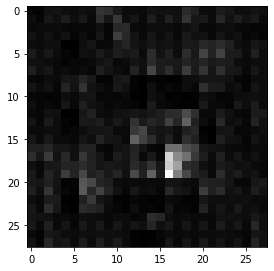

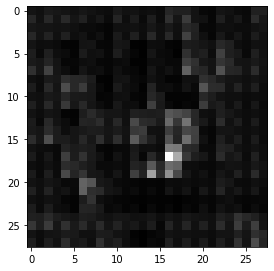

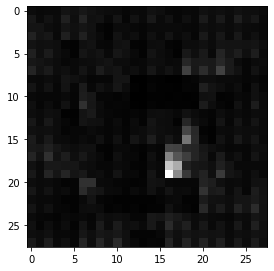

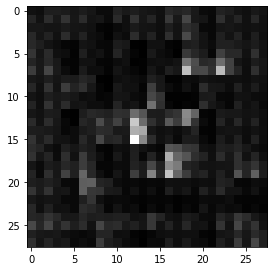

In [0]:
model = models[2]
model.eval()
model.to("cpu")

bottleneckSize=10
numimgs = 5

with torch.no_grad():
  rndnoise =torch.randn(numimgs,bottleneckSize)
  genimages = model.decoder(rndnoise).numpy()
  
for i in range(numimgs):
  img = np.squeeze(genimages[i])
  fig = plt.figure(figsize = (25,25))
  ax = fig.add_subplot(1,5,i+1)
  ax.imshow(img, cmap = 'gray')

# Exercice 2

In [0]:
hparams_class = {
    'batch_size':50,
    'num_epochs':100,
    'val_batch_size':50,
    'test_batch_size':50,
    'hidden_size':50,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-2,
    'log_interval':100,
    'bottleneck_size':10
}

In [0]:
class FeatureClassifier(nn.Module):
  
  def __init__(self, feature_extractor, feature_size, hidden_size, nclasses):
    super().__init__()
    self.feature_extractor = feature_extractor
    
    self.classifier = nn.Sequential(
        torch.nn.Linear(feature_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, nclasses),
        #torch.nn.Softmax(dim=-1)
    )
    

  def forward(self, x):
    out = self.feature_extractor(x)
    out = self.classifier(out)
    return out


In [0]:
m = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 100, 10)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(m)

14920

In [0]:
# From 
def accuracy(output, target):
  """Computes the accuracy for multiple binary predictions"""
  _, index = torch.max(output, dim=1)
  well_predictions = torch.eq(index, target)
  acc = torch.sum(well_predictions, 0)
  
  return acc.float()


In [0]:
def validate(hparams_class, classifier, crit, valid_dataloader, device):
  classifier.eval()

  n = 0
  with torch.no_grad():
    loss = 0
    acc = 0

    for x, label in valid_dataloader:
      x, label = x.to(device), label.to(device)
      
      pred = classifier(x)

      acc += accuracy(pred, label)
      loss += crit(pred, label)
      
      n += label.numel()
  loss = loss / n
  acc = acc / n

  return loss, acc
    

In [0]:
def watch_img(num=2,loader=None ):
  digits = []
  for i in range(num):
    iterator = iter(loader)
    images, _ = iterator.next()

    # Get first image of the batch
    digits.append(images.numpy()[0])

  fig, axes = plt.subplots(nrows=1, ncols=num, sharex=True, sharey=True, figsize=(25,4))

  for images, ax in zip(digits, axes):
      for img in images:
          ax.imshow(np.squeeze(img), cmap='gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

In [0]:
def train_classifier(hparams_class, classifier, optim, crit, train_dataloader, valid_dataloader, device, name):
  
  classifier.to(device)
  classifier.train()

  N_epoch = hparams_class["num_epochs"]

  metrics =  {"batch_num": [],
              "batch_nums": [],
              "batch_train_loss": [],
              "batchs_train_loss":[],
              "epoch_num": [],
              "epoch_val_loss": [],
              "epoch_val_acc": [],
              "epoch_train_loss": [],
              "epoch_train_acc": []
              }


  for n in range(N_epoch):
    for i, (input_batch, target_batch) in enumerate(train_dataloader):
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
      optim.zero_grad()
      prediction = classifier(input_batch)

      loss = crit(prediction, target_batch) / prediction.numel()

      loss.backward()
      optim.step()

      metrics["batch_num"].append(i+1)
      metrics["batch_train_loss"].append(loss.detach().cpu().numpy())

      
    val_loss, val_acc = validate(hparams_class, classifier, crit, valid_dataloader, device)
    
    metrics["epoch_num"].append(n+1)
    metrics["epoch_val_loss"].append(val_loss.detach().cpu().numpy())
    metrics["epoch_val_acc"].append(val_acc.detach().cpu().numpy())
    metrics["epoch_train_loss"].append(np.mean(metrics["batch_train_loss"]))
    metrics["batchs_train_loss"].extend(metrics["batch_train_loss"])
    metrics["batch_nums"] += metrics["batch_num"]

    print("Epoch {}, Loss: {:.6f}, Acc_val: {:.1f}%,  {}".format(metrics["epoch_num"][n], metrics["epoch_val_loss"][n], metrics["epoch_val_acc"][n]*100, name))
    
    
  metrics = {k: np.array(metrics[k]) for k in metrics.keys()}
  print("-"*55)

  return metrics

Thus we have 2 full batches of train and 60 full batches of validation


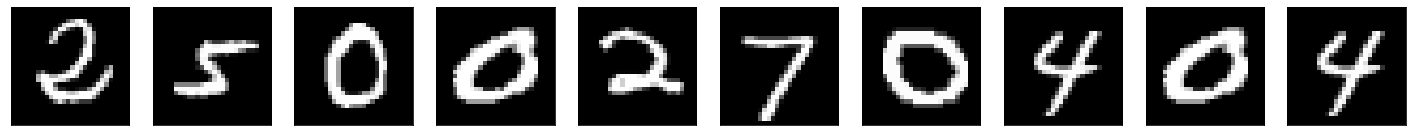

In [0]:
encoder_decoder = models[2]

# From scatch
model_scratch = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 
                                  hparams_class["hidden_size"], hparams_class["num_classes"])



#Initialize with pretrained ecoder
model_pretrained1 = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 
                                      hparams_class["hidden_size"], hparams_class["num_classes"])
model_pretrained1.feature_extractor.load_state_dict(encoder_decoder.encoder.state_dict())

#Initialize with pretrained ecoder
model_pretrained2 = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 
                                      hparams_class["hidden_size"], hparams_class["num_classes"])
model_pretrained2.feature_extractor.load_state_dict(encoder_decoder.encoder.state_dict())


small_train_dataset , _ = torch.utils.data.random_split(train_dataset, [100, len(train_dataset) - 100])

small_train_dataloader = torch.utils.data.DataLoader(small_train_dataset, batch_size = hparams_class["batch_size"], shuffle=True)

small_validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size = hparams_class['val_batch_size'], shuffle=True,drop_last=True)




crit = nn.CrossEntropyLoss(reduction="sum")  #nn.BCELoss()


optim1 = optim.Adam(model_scratch.parameters(), lr = hparams['learning_rate']) #From scratch same lr
optim2 = optim.Adam(model_pretrained1.classifier.parameters(), lr = hparams['learning_rate']) #From encoder weights same lr
optim3 = optim.Adam([{"params": model_pretrained2.feature_extractor.parameters(), "lr": hparams['learning_rate']/100}, 
                     {"params": model_pretrained2.classifier.parameters(), "lr": hparams['learning_rate']}],)  #From encoder weights diferent lr



watch_img(10, small_train_dataloader)
print("Thus we have {} full batches of train and {} full batches of validation".format(len(small_train_dataloader),len(small_validation_dataloader )))

In [0]:
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print(device)

model1 = train_classifier(hparams_class, model_scratch, optim1, crit, small_train_dataloader, small_validation_dataloader, device, name="Scratch")
model2 = train_classifier(hparams_class, model_pretrained1, optim2, crit, small_train_dataloader, small_validation_dataloader, device, name="Freeze enc")
model3 = train_classifier(hparams_class, model_pretrained2, optim3, crit, small_train_dataloader, small_validation_dataloader, device, name="Small LR enc")



cuda
Epoch 1, Loss: 2.304461, Acc_val: 9.5%,  Scratch
Epoch 2, Loss: 2.302641, Acc_val: 9.5%,  Scratch
Epoch 3, Loss: 2.300769, Acc_val: 9.5%,  Scratch
Epoch 4, Loss: 2.298447, Acc_val: 9.5%,  Scratch
Epoch 5, Loss: 2.295552, Acc_val: 12.0%,  Scratch
Epoch 6, Loss: 2.292016, Acc_val: 14.6%,  Scratch
Epoch 7, Loss: 2.287640, Acc_val: 11.1%,  Scratch
Epoch 8, Loss: 2.282221, Acc_val: 11.2%,  Scratch
Epoch 9, Loss: 2.275157, Acc_val: 13.0%,  Scratch
Epoch 10, Loss: 2.266237, Acc_val: 15.8%,  Scratch
Epoch 11, Loss: 2.255003, Acc_val: 18.9%,  Scratch
Epoch 12, Loss: 2.241161, Acc_val: 23.3%,  Scratch
Epoch 13, Loss: 2.223876, Acc_val: 25.2%,  Scratch
Epoch 14, Loss: 2.203353, Acc_val: 26.2%,  Scratch
Epoch 15, Loss: 2.179795, Acc_val: 28.0%,  Scratch
Epoch 16, Loss: 2.152892, Acc_val: 28.1%,  Scratch
Epoch 17, Loss: 2.121245, Acc_val: 29.2%,  Scratch
Epoch 18, Loss: 2.083527, Acc_val: 30.9%,  Scratch
Epoch 19, Loss: 2.040860, Acc_val: 31.3%,  Scratch
Epoch 20, Loss: 2.001313, Acc_val: 32.1

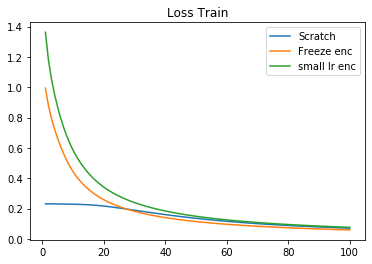

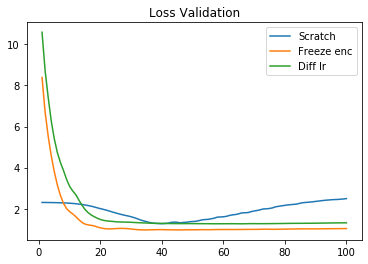

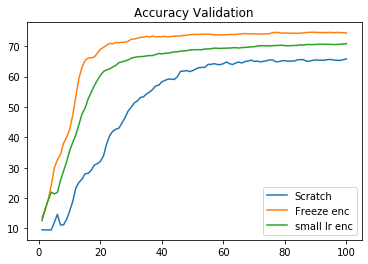

In [0]:

#Loss train Plot
plt.figure()
plt.title("Loss Train")
plt.plot(model1["epoch_num"], model1["epoch_train_loss"], label="Scratch")
plt.plot(model2["epoch_num"], model2["epoch_train_loss"], label="Freeze enc")
plt.plot(model3["epoch_num"], model3["epoch_train_loss"], label="small lr enc")
plt.legend()

#Loss Validation Plot
plt.figure()
plt.title("Loss Validation")
plt.plot(model1["epoch_num"], model1["epoch_val_loss"], label="Scratch")
plt.plot(model2["epoch_num"], model2["epoch_val_loss"], label="Freeze enc")
plt.plot(model3["epoch_num"], model3["epoch_val_loss"], label="Diff lr")
plt.legend()

#Accuracy Validation Plot
plt.figure()
plt.title("Accuracy Validation")
plt.plot(model1["epoch_num"], model1["epoch_val_acc"]*100, label="Scratch")
plt.plot(model2["epoch_num"], model2["epoch_val_acc"]*100, label="Freeze enc")
plt.plot(model3["epoch_num"], model3["epoch_val_acc"]*100, label="small lr enc")
plt.legend()




# Exercici Optional A

In [0]:
from torch.autograd.variable import Variable


In [0]:
class Encoder(nn.Module):
   ''' 
   This the encoder part of the VAE
   '''
   def __init__(self, bottleneck):
     super().__init__()

     self.conv1 = nn.Conv2d(1,32,3,padding=1)
     self.pool  = nn.MaxPool2d(2,2)
     self.conv2 = nn.Conv2d(32,16,3,padding=1)
     self.conv3 = nn.Conv2d(16,8,3,padding=1)
     self.fc      = nn.Linear(8*7*7, bottleneck)
     self.media = nn.Linear(bottleneck,bottleneck)
     self.logvar  = nn.Linear(bottleneck,bottleneck)

   def forward(self,x):
      ## encode ##


      x = F.relu(self.conv1(x))
      x = self.pool(x)
      x = F.relu(self.conv2(x))
      x = self.pool(x)
      x = F.relu(self.conv3(x))
      x = x.view(-1, 8*7*7)
      x = F.relu(self.fc(x))
      z_media = self.media(x)
      logvar   = self.logvar(x)

      return z_media, logvar

class Decoder(nn.Module):
   ''' 
   This the decoder part of the VAE
   '''

   def __init__(self, bottleneck):
     super().__init__()

     ## decoder layers ##
     ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
     self.linear = nn.Linear(bottleneck, 8*7*7)
     self.t_conv1 = nn.ConvTranspose2d(8, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 32, 2, stride=2)
     self.t_conv3 = nn.ConvTranspose2d(32,1,1)

   def forward(self,x):
     ## decode ##
     x = F.relu(self.linear(x))
     x = x.view(-1, 8, 7, 7)
     x = F.relu(self.t_conv1(x))
     # output layer (with sigmoid for scaling from 0 to 1)
     x = F.relu(self.t_conv2(x))
     x = torch.sigmoid(self.t_conv3(x))
            
     return x

class VAE(nn.Module):
  '''
  This takes both encoder and decoder into the same network
  '''
  def __init__(self, enc, dec):
    super().__init__()

    self.encoder = enc
    self.decoder = dec

  def forward(self,x):
    #encode
    z_media,logvar = self.encoder(x)
  
    # Reparametrization trick
    std = torch.exp(0.5*logvar)
    # Standard Gaussian with correct size
    eps = torch.randn_like(std)
    # This allows for the gradients to flow
    x_sample = z_media + eps*std
 
    #Decode
    predicted = self.decoder(x_sample)

    return predicted,z_media,logvar
      

In [0]:
def lossFunction(data,z_mu,logvar,prediction):
    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(prediction, data, reduction='sum')
    # KL divergence loss
    kld = -0.5 * torch.sum(1+logvar - z_mu.pow(2) - logvar.exp()) * 600 #This 600 is the disentangle parameter.

    # total loss
    loss = recon_loss + kld
    return loss, recon_loss, kld


def train(model, num_epochs):
  # Prepare the GPU and the model to start training
  model.train()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr = hparams['learning_rate']) # learning rate chosen at random
  
  for epoch in range(num_epochs):
    # For tracking the loss of the model
    closs = 0
    crl, ckdl = 0, 0
    for batch_idx, (data,_) in enumerate(train_loader):
      # Put data and label into GPU
      data = data.to(device)
      
      # What does the model say 
      prediction, z_mu,logvar = model(data)
      loss, rl, kdl = lossFunction(data,z_mu,logvar,prediction)
      closs += loss.item() 
      crl += rl
      ckdl += kdl
      # Name a more iconic trio
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    print('Epoch: {} \tRecon Loss: {:.6f}\tKDL Loss: {:.6f}'.format(epoch+1,crl/len(mnist_trainset), ckdl/len(mnist_trainset)))  



In [0]:
BotNeck = 20

encoder = Encoder(BotNeck)
decoder = Decoder(BotNeck)
model = VAE(encoder,decoder)


train(model,10)

Epoch: 1 	Recon Loss: -7500.272949	KDL Loss: 39.945381
Epoch: 2 	Recon Loss: -8726.192383	KDL Loss: 61.103527
Epoch: 3 	Recon Loss: -7756.066406	KDL Loss: 58.892128
Epoch: 4 	Recon Loss: -7388.020996	KDL Loss: 62.092087
Epoch: 5 	Recon Loss: -6915.199707	KDL Loss: 72.237556
Epoch: 6 	Recon Loss: -6421.664551	KDL Loss: 88.043625
Epoch: 7 	Recon Loss: -6324.267090	KDL Loss: 106.018471
Epoch: 8 	Recon Loss: -6282.588867	KDL Loss: 136.746750
Epoch: 9 	Recon Loss: -6121.398438	KDL Loss: 201.155106
Epoch: 10 	Recon Loss: -5990.613770	KDL Loss: 256.200775


torch.Size([1, 20])
torch.Size([28, 28])


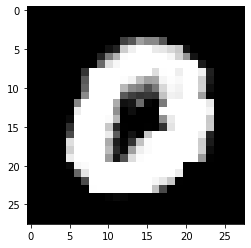

In [0]:
# sample and generate a image
z = torch.randn(1, BotNeck)
model.to("cpu")
# run only the decoder
reconstructed_img = model.decoder(z)

# Go home and run this.
print(z.shape)
print(reconstructed_img.detach().squeeze().shape)

plt.imshow(reconstructed_img.detach().squeeze().numpy(), cmap='gray')

# Exercice Optional B



In [0]:
from torch.autograd.variable import Variable
import random
import math
from torchvision import utils
from PIL import Image


In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()

def id_to_onehot(id):
    tgt = torch.zeros(id.shape[0], 10)
    for i in range(tgt.shape[0]):
      tgt[i, int(id[i])] = 1.0
    return tgt.float().cuda()



def rand_labels(size):
    lbls = torch.zeros(size, 10)
    for i in range(size):
        clss_i = random.randint(0, 9)
        lbls[i, clss_i] = 1
    #return torch.randint(low=0, high=10, size=[size, 1]).float().cuda()
    return lbls.float().cuda()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

In [0]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
      
        self._fc = torch.nn.Linear(100 + 10, 1024*4*4)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x, labs):
        # Noise to image
        x = torch.cat([x, labs], dim=1)
        x = self._fc(x)
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        return self._conv3(x)

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._fc1 = nn.Sequential(
            nn.Linear(512*4*4 + 10, 100),
            nn.ReLU()
        )
        self._fc2 = nn.Sequential(
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labs):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        x = x.view(-1, 512*4*4)
        x = torch.cat([x, labs], dim=1)
        x = self._fc1(x)
        x = self._fc2(x)
        return x

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def gen_nonmatching_labels(self, labels):
        labels_tgt = torch.zeros(*labels.shape)
        for i in range(labels.shape[0]):
            j = random.randint(0, 9)
            while labels[i, j] != 0:
                j = random.randint(0, 9)
            labels_tgt[i, j] = 1
        return labels_tgt.cuda()


    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    def generate_samples(self, batch_size, z=None, lab=None):
        # sample random noise
        if z is None:
            z = norm_noise(batch_size)
        if lab is None:
            lab = rand_labels(batch_size)


        # TODO: generate fake samples out of the random noise z
        fake_samples = self._generator(z, lab)
        return fake_samples, lab
    
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples, real_labels):
        # generate fake samples
        fake_samples, fake_labels = self.generate_samples(real_samples.size(0))

        # optimize generator
        loss_g = self._step_opt_g(fake_samples, fake_labels)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, real_labels, fake_samples.detach(), fake_labels.detach())
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, fake_labels):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # TODO: Calculate generator loss
        estim_fake = self._discriminator(fake_samples, fake_labels)

        # Generate fake sample target
        # tgt = torch.zeros(estim_fake.shape[0], 1)

        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, real_labels, fake_samples, fake_labels):
        # Reset gradients
        self._opt_d.zero_grad()

        # Calculate discriminator loss for real samples
        estim_real = self._discriminator(real_samples, real_labels)
        loss_real = self._criterion(estim_real, self._label_real)

      
        # Calculate discriminator loss for fake samples
        estim_fake = self._discriminator(fake_samples, fake_labels)
        loss_fake = self._criterion(estim_fake, self._label_fake)

        # Calculate discriminator loss for non-matching labels and images
        fake_labels2 = self.gen_nonmatching_labels(real_labels)
        estim_real_fakelabs = self._discriminator(real_samples, fake_labels2)
        loss_nonmatching = self._criterion(estim_real_fakelabs, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake + loss_nonmatching) / 3
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item(), loss_nonmatching.item()
        
  

In [0]:
num_epochs = 30
num_val_samples = 25
batch_size
z_val = norm_noise(num_val_samples)

labs_val = torch.zeros(num_val_samples, 10)

for i in range(num_val_samples):
    labs_val[i, i%10] = 1
labs_val = labs_val.float().cuda()



model = Model(batch_size)

Train for 10 epochs and it works:

epoch: 0/30, batch: 0/600, G_loss: 0.6623009443283081, D_loss: (0.6620059013366699, 0.7249764800071716, 0.725419282913208)


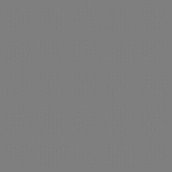

epoch: 0/30, batch: 10/600, G_loss: 0.8124727010726929, D_loss: (0.790473222732544, 0.586601734161377, 0.6037750244140625)
epoch: 0/30, batch: 20/600, G_loss: 1.2954635620117188, D_loss: (0.7717682719230652, 0.32002121210098267, 0.6205602884292603)
epoch: 0/30, batch: 30/600, G_loss: 2.08158802986145, D_loss: (0.6469388008117676, 0.13337013125419617, 0.7437819838523865)
epoch: 0/30, batch: 40/600, G_loss: 2.8043057918548584, D_loss: (0.7701977491378784, 0.0628218948841095, 0.6235710382461548)
epoch: 0/30, batch: 50/600, G_loss: 3.1455349922180176, D_loss: (0.8286125063896179, 0.04429381713271141, 0.5747913122177124)
epoch: 0/30, batch: 60/600, G_loss: 3.1926801204681396, D_loss: (0.7321226000785828, 0.04433383420109749, 0.6598563194274902)
epoch: 0/30, batch: 70/600, G_loss: 3.640130043029785, D_loss: (0.6675336360931396, 0.02722623199224472, 0.7237603664398193)
epoch: 0/30, batch: 80/600, G_loss: 3.9399054050445557, D_loss: (0.7518877387046814, 0.019966911524534225, 0.6400424242019653

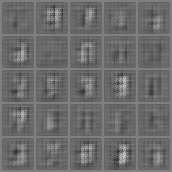

epoch: 0/30, batch: 110/600, G_loss: 3.566051721572876, D_loss: (1.009271264076233, 0.029915262013673782, 0.4624045491218567)
epoch: 0/30, batch: 120/600, G_loss: 3.5445096492767334, D_loss: (0.7274066209793091, 0.031027901917696, 0.6700354814529419)
epoch: 0/30, batch: 130/600, G_loss: 0.8098466992378235, D_loss: (0.37268736958503723, 0.6046581864356995, 1.170166015625)
epoch: 0/30, batch: 140/600, G_loss: 4.026899337768555, D_loss: (0.8725419640541077, 0.01860796846449375, 0.5478507876396179)
epoch: 0/30, batch: 150/600, G_loss: 3.1788337230682373, D_loss: (0.6220842003822327, 0.04355272650718689, 0.7711321115493774)
epoch: 0/30, batch: 160/600, G_loss: 4.101778984069824, D_loss: (0.8165615797042847, 0.01751043274998665, 0.587714433670044)
epoch: 0/30, batch: 170/600, G_loss: 1.302972435951233, D_loss: (0.9204474687576294, 0.32203906774520874, 0.51564621925354)
epoch: 0/30, batch: 180/600, G_loss: 2.799881935119629, D_loss: (0.7790358066558838, 0.06938453763723373, 0.622881293296814)

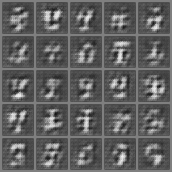

epoch: 0/30, batch: 210/600, G_loss: 3.543416738510132, D_loss: (1.015259861946106, 0.03132185339927673, 0.4646119773387909)
epoch: 0/30, batch: 220/600, G_loss: 3.8772475719451904, D_loss: (0.7507240772247314, 0.02161703258752823, 0.6423556804656982)
epoch: 0/30, batch: 230/600, G_loss: 4.2073974609375, D_loss: (0.7746331095695496, 0.015660148113965988, 0.622779905796051)
epoch: 0/30, batch: 240/600, G_loss: 3.6803689002990723, D_loss: (0.6402111649513245, 0.026659168303012848, 0.7521936297416687)
epoch: 0/30, batch: 250/600, G_loss: 4.071630477905273, D_loss: (0.6641474962234497, 0.018037788569927216, 0.7244135141372681)
epoch: 0/30, batch: 260/600, G_loss: 4.418842315673828, D_loss: (0.7948464751243591, 0.01278054341673851, 0.6083849668502808)
epoch: 0/30, batch: 270/600, G_loss: 1.3206478357315063, D_loss: (0.9898033738136292, 0.32562434673309326, 0.4652358591556549)
epoch: 0/30, batch: 280/600, G_loss: 2.812142848968506, D_loss: (0.9955242276191711, 0.06549863517284393, 0.47188118

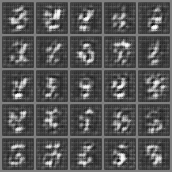

epoch: 0/30, batch: 310/600, G_loss: 2.401165246963501, D_loss: (1.0858901739120483, 0.09944763034582138, 0.4222291111946106)
epoch: 0/30, batch: 320/600, G_loss: 3.3264365196228027, D_loss: (0.8502624034881592, 0.03899124264717102, 0.5694944858551025)
epoch: 0/30, batch: 330/600, G_loss: 1.0188627243041992, D_loss: (0.9151392579078674, 0.4521521031856537, 0.5127663612365723)
epoch: 0/30, batch: 340/600, G_loss: 2.6714589595794678, D_loss: (1.059262990951538, 0.07846041768789291, 0.42718756198883057)
epoch: 0/30, batch: 350/600, G_loss: 1.6912741661071777, D_loss: (0.8111637830734253, 0.21727828681468964, 0.58732670545578)
epoch: 0/30, batch: 360/600, G_loss: 2.6915290355682373, D_loss: (0.8877557516098022, 0.07458589971065521, 0.5307561755180359)
epoch: 0/30, batch: 370/600, G_loss: 0.6888812780380249, D_loss: (0.6455773115158081, 0.6980360150337219, 0.741263747215271)
epoch: 0/30, batch: 380/600, G_loss: 1.1573526859283447, D_loss: (0.964938223361969, 0.3798701763153076, 0.4791906476

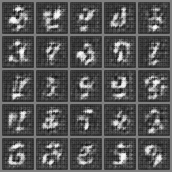

epoch: 0/30, batch: 410/600, G_loss: 3.763456344604492, D_loss: (0.7598904967308044, 0.02711821347475052, 0.6343271732330322)
epoch: 0/30, batch: 420/600, G_loss: 2.1852939128875732, D_loss: (0.6526998281478882, 0.12872159481048584, 0.73521888256073)
epoch: 0/30, batch: 430/600, G_loss: 0.6701828241348267, D_loss: (0.546678364276886, 0.7198345065116882, 0.8650490045547485)
epoch: 0/30, batch: 440/600, G_loss: 0.8796998858451843, D_loss: (0.7683075070381165, 0.5378113985061646, 0.6265196800231934)
epoch: 0/30, batch: 450/600, G_loss: 2.9710211753845215, D_loss: (1.0816320180892944, 0.06346634775400162, 0.41651245951652527)
epoch: 0/30, batch: 460/600, G_loss: 1.1006178855895996, D_loss: (0.9551438689231873, 0.40585848689079285, 0.48433417081832886)
epoch: 0/30, batch: 470/600, G_loss: 3.481167793273926, D_loss: (0.9543684124946594, 0.033830877393484116, 0.4886929392814636)
epoch: 0/30, batch: 480/600, G_loss: 0.6890318989753723, D_loss: (0.5964711308479309, 0.700568675994873, 0.80412977

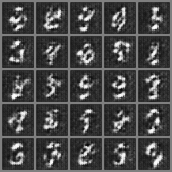

epoch: 0/30, batch: 510/600, G_loss: 3.9431498050689697, D_loss: (1.2028701305389404, 0.024372069165110588, 0.36444252729415894)
epoch: 0/30, batch: 520/600, G_loss: 3.53908634185791, D_loss: (0.9015139937400818, 0.03367190808057785, 0.5229387879371643)
epoch: 0/30, batch: 530/600, G_loss: 1.9227615594863892, D_loss: (0.6938334703445435, 0.16928182542324066, 0.6918901801109314)
epoch: 0/30, batch: 540/600, G_loss: 0.6920574307441711, D_loss: (0.5596729516983032, 0.6980187296867371, 0.850679874420166)
epoch: 0/30, batch: 550/600, G_loss: 2.600105047225952, D_loss: (1.0007840394973755, 0.08542570471763611, 0.45854294300079346)
epoch: 0/30, batch: 560/600, G_loss: 0.8857253193855286, D_loss: (0.7476558089256287, 0.53290194272995, 0.6421675682067871)
epoch: 0/30, batch: 570/600, G_loss: 1.1412019729614258, D_loss: (0.8598777651786804, 0.39550700783729553, 0.5516030788421631)
epoch: 0/30, batch: 580/600, G_loss: 2.9022436141967773, D_loss: (0.8690084218978882, 0.06596118956804276, 0.5525383

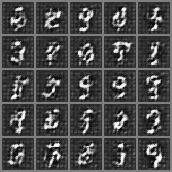

epoch: 1/30, batch: 10/600, G_loss: 1.1711361408233643, D_loss: (1.0310817956924438, 0.3730032742023468, 0.44230812788009644)
epoch: 1/30, batch: 20/600, G_loss: 1.2481400966644287, D_loss: (1.0528903007507324, 0.3407163918018341, 0.43177786469459534)
epoch: 1/30, batch: 30/600, G_loss: 1.0710937976837158, D_loss: (0.8916583061218262, 0.4216984808444977, 0.5292741656303406)
epoch: 1/30, batch: 40/600, G_loss: 0.9529189467430115, D_loss: (0.8363957405090332, 0.48938509821891785, 0.5642297267913818)
epoch: 1/30, batch: 50/600, G_loss: 1.293652057647705, D_loss: (1.064731478691101, 0.3227662146091461, 0.422659307718277)
epoch: 1/30, batch: 60/600, G_loss: 0.9506999254226685, D_loss: (0.7033509016036987, 0.49394112825393677, 0.6869043111801147)
epoch: 1/30, batch: 70/600, G_loss: 1.3844223022460938, D_loss: (0.9393752813339233, 0.2918383479118347, 0.49729374051094055)
epoch: 1/30, batch: 80/600, G_loss: 2.868490695953369, D_loss: (0.9894788265228271, 0.07416396588087082, 0.4809489548206329

KeyboardInterrupt: ignored

In [0]:
for epoch in range(num_epochs):

    # Train epoch
    for n_batch, (real_samples,real_labels) in enumerate(data_loader):
        
        # Prepare batch data
        real_samples = Variable(real_samples).cuda()
        real_labels = Variable(real_labels).float().cuda()
        # Update model weights
        loss_g, loss_d = model.step_optimization(real_samples, id_to_onehot(real_labels))
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        if (n_batch) % 100 == 0:
            val_fake_samples = model.generate_samples(num_val_samples, z=z_val, lab=labs_val)[0].data.cpu()
            display_batch_images(val_fake_samples)

In [0]:
def print_images(target_num):
  print(target_num)
  labs_val2 = torch.zeros(25, 10)
  for i in range(25):
      labs_val2[i, target_num] = 1.0
  labs_val2 = labs_val2.cuda()

  val_fake_samples = model.generate_samples(num_val_samples, z=norm_noise(25), lab=labs_val2)[0].data.cpu()
  display_batch_images(val_fake_samples)


0


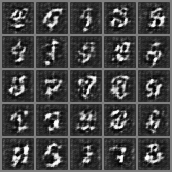

1


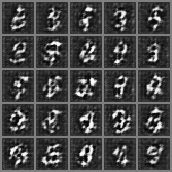

2


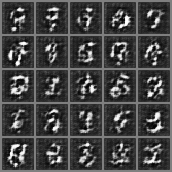

3


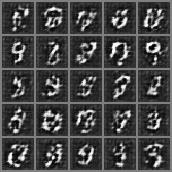

4


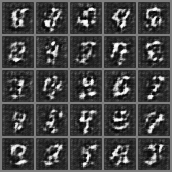

5


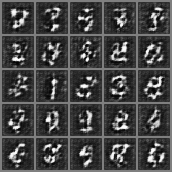

6


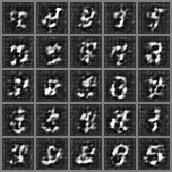

7


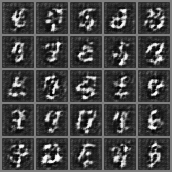

8


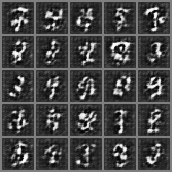

9


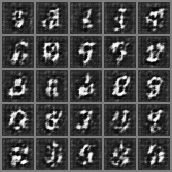

In [0]:
for i in range(10):
  print_images(i)